# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, sys
sys.path.insert(1, '..')
import project_tests as t
%matplotlib inline

# load recommender library
import ask_watson as ask

df = pd.read_csv('../data/user-item-interactions.csv')
df_content = pd.read_csv('../data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

Unique Users: 5148
Unique Article in Interactions: 714
Unique Articles: 1051
User Mean Interactions: 8.930847


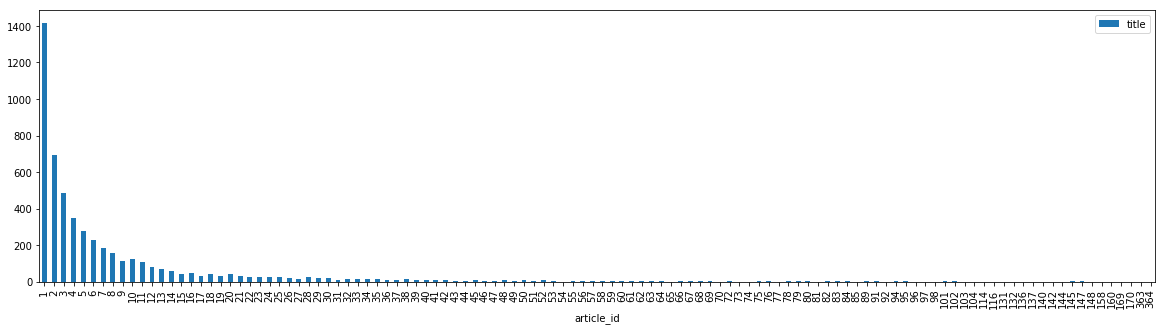

In [3]:
print("Unique Users: {}".format(df['email'].dropna().unique().shape[0]))
print("Unique Article in Interactions: {}".format(df.dropna(subset=['email'])['article_id'].unique().shape[0]))
print("Unique Articles: {}".format(df_content['article_id'].unique().shape[0]))

interactions = df.dropna(subset=['email']).groupby('email').count()
print("User Mean Interactions: {:.6f}".format(interactions['article_id'].mean()))
interactions.groupby('article_id').count().plot.bar(figsize=(20, 5));

As with most only interactions, the distribution follows the [power law](https://en.wikipedia.org/wiki/Power_law) - in particular [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law).

In [4]:
items = df.groupby(['email', 'article_id'])['title'].count().reset_index().groupby('email').count()['article_id']
articles = 3
users = items.count()
below = items[items <= articles].count()

print("Of {} users {} iteract with {} articles or less ({:.2%}) - Total Mean interactions per article: {:.4f}".format(users, below, articles, below/users, items.mean()))

Of 5148 users 2833 iteract with 3 articles or less (55.03%) - Total Mean interactions per article: 6.5402


In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby(['email', 'article_id'])['title'].count().reset_index().groupby('email').count()['article_id'].median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.dropna(subset=['email']).groupby(['email'])['article_id'].count().max() # The maximum number of user-article interactions by any 1 user is ______.
print("Median: {}".format(median_val))
print("Max interactions of one user with the system: {}".format(max_views_by_user))

Median: 3.0
Max interactions of one user with the system: 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# duplicate user interactions (however, these should just indicate multiple interactions from a single user)
df[df.duplicated()].head()

,article_id,title,email
41,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
75,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
95,1162.0,analyze energy consumption in buildings,d385b6c44711688ce2a33eb596495bf9243e1750
97,409.0,using github for project control in dsx,2b6c0f514c2f2b04ad3c4583407dccd0810469ee
99,1393.0,the nurse assignment problem,8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e


In [7]:
# duplicate content
dup = df_content['article_id'].duplicated()
df_content[dup]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [8]:
df_content[df_content['article_id'].isin(df_content['article_id'][dup])].sort_values(by='article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


Appears that the articles have the same full name, however the `doc_body` or `doc_description` changed slightly.

In [9]:
# drop duplicates
df_content = df_content[dup == False]

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
len(df)

45993

In [11]:
ver = [int(x) for x in pd.__version__.split('.')]
ver[0] == 0

True

In [12]:
unique_articles = len(df['article_id'].unique()) # The number of unique articles that have at least one interaction
total_articles = len(df_content['article_id'].unique()) # The number of unique articles on the IBM platform
unique_users = len(df['email'].dropna().unique()) # The number of unique users
user_article_interactions = len(df) # The number of user-article interactions
print("There are {} articles of {} total that have an interaction.".format(unique_articles, total_articles))
print("There are {} users with a total of {} interactions".format(unique_users, user_article_interactions))

There are 714 articles of 1051 total that have an interaction.
There are 5148 users with a total of 45993 interactions


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
article_views = df.groupby('article_id').count()['email'].reset_index().sort_values(by='email', ascending=False)
article_views.head()

,article_id,email
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627


In [14]:
most_viewed_article_id = str(article_views.iloc[0, 0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = article_views.iloc[0, 1] # The most viewed article in the dataset was viewed how many times?
print("Article {} was most viewed ({} views)".format(most_viewed_article_id, max_views))

Article 1429.0 was most viewed (937 views)


In [15]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [16]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    tf = ask.transformer.RankingTransformer(['title'], id_col='article_id', agg_fcts=['count'], ascending=False)
    ids = tf.transform(df).head(n)
    # retrieve relevant names from list
    top_articles = ids.join(df.groupby('article_id').first()[['title']])['title'].values
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    tf = ask.transformer.RankingTransformer(['title'], id_col='article_id', agg_fcts=['count'], ascending=False)
    top_articles = list(tf.transform(df).head(n).index.astype(str))
    return top_articles # Return the top article ids

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification'
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'predicting churn with the spss random tree algorithm'
 'healthcare python streaming application demo'
 'finding optimal locations of new store using decision optimization'
 'apache spark lab, part 1: basic concepts'
 'analyze energy consumption in buildings'
 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [19]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    tf = ask.transformer.UserItemTransformer(user_col='user_id', item_col='article_id', value_col='title', binarize=True)
    user_item = tf.transform(df)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    tf = ask.transformer.SimilarityTransformer(cols=(0, -1), normalize=False)
    sim = tf.transform(user_item)

    # create list of just the ids
    rec = ask.recommender.SimilarityRecommender(None).fit(sim)
    most_similar_users = rec.predict([user_id])[0]
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870   46 4201 5041]
The 5 most similar users to user 3933 are: [   1   23 3782 4459  203]
The 3 most similar users to user 46 are: [4201   23 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # convert (as items as indexed as flaots)
    article_ids = np.array(article_ids).astype('float')
    article_names = df.groupby('article_id').first().loc[article_ids, 'title'].values
    return article_names

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # retrieve the ids based on the relevant columns
    article_ids = user_item.loc[user_id]
    article_ids = list(article_ids[article_ids > 0].index.astype('str'))
    # use previous function
    article_names = get_article_names(article_ids, df)
    return article_ids, article_names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # recalc sim matrix
    tf = ask.transformer.SimilarityTransformer(cols=(0, -1), normalize=False)
    sim = tf.transform(user_item)
    
    # create the recommender
    rec = ask.recommender.CrossSimilarityRecommender(m, filter=lambda x: x>0).fit((user_item, sim))
    
    # calculate recommendations
    recs = rec.predict([user_id])[0]
    return recs

In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['this week in data science (april 18, 2017)',
       'timeseries data analysis of iot events by using jupyter notebook',
       'got zip code data? prep it for analytics. – ibm watson data lab – medium',
       'higher-order logistic regression for large datasets',
       'using machine learning to predict parking difficulty',
       'deep forest: towards an alternative to deep neural networks',
       'experience iot with coursera',
       'using brunel in ipython/jupyter notebooks',
       'graph-based machine learning',
       'the 3 kinds of context: machine learning and the art of the frame'],
      dtype=object)

In [26]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # optionally use user_item here to calculate similarity (computationally expensive)
    tf = ask.transformer.SimilarityTransformer(cols=(0, -1), normalize=False)
    sim = tf.transform(user_item)
    
    # select the list of users that are similar
    sim_users = pd.DataFrame(sim.loc[user_id])
    sim_users.columns=['similarity']
    
    # calculate the number of interactions for the given user
    user_interact = pd.DataFrame(user_item.sum(axis=1), columns=['num_interactions'])
    
    # setup final df
    neighbors_df = sim_users.join(user_interact).sort_values(by=['similarity', 'num_interactions'], ascending=False)
    neighbors_df = neighbors_df.drop(user_id)
    neighbors_df = neighbors_df.reset_index().rename(columns={'index': 'neighbor_id'})
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # recalc sim matrix
    tf = ask.transformer.SimilarityTransformer(cols=(0, -1), normalize=False)
    sim = tf.transform(user_item)
    
    # create the recommender
    sim_rec = lambda: ask.recommender.SimilarityRecommender(sort='count', ascending=False)
    rec = ask.recommender.CrossSimilarityRecommender(m, filter=lambda x: x>0, similarity=sim_rec).fit((user_item, sim))
    
    # calculate recommendations
    recs = rec.predict([user_id])[0]
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [28]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[ 43. 109. 111. 112. 164. 213. 225. 313. 337. 379.]

The top 10 recommendations for user 20 are the following article names:
['deep learning with tensorflow course by big data university'
 'tensorflow quick tips' 'tidy up your jupyter notebooks with scripts'
 'building custom machine learning algorithms with apache systemml'
 'learn tensorflow and deep learning together and now!'
 'modeling energy usage in new york city'
 'a visual explanation of the back propagation algorithm for neural networks'
 'what is machine learning?' 'generalization in deep learning'
 'data structures related to machine learning algorithms']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [29]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1)['neighbor_id'].values[0]
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].values[10]

print("Most similar to 1: {} / 10th most similar to 131: {}".format(user1_most_sim, user131_10th_sim))

Most similar to 1: 3933 / 10th most similar to 131: 242


In [30]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

***Answer:*** As we have no information about the user, the most relevant functions owuld be `get_top_articles`. This would allow us to recommend the best articles in general. A better approach would be, to have a questionair for users on login to identify general information (e.g. ask which of the popular items she/he likes). In that case we could leverage this information to make better recommendations. We might also use a querying or filtering system for the user to ask for topics of interest.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [31]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs = get_top_article_ids(10)



In [32]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [33]:
# download pre-trained glove embeddings (only run if not downloaded already)
ask.glove.download('twitter')

File found, no download needed


True

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.spatial.distance import cosine

def create_rec(emb_type='glove', df=df, df_content=df_content, user_item=user_item):
    '''Creates a recommender module.
    
    This is just a workaround to build a full class, because I am lazy.
    
    Args:
        emb_type (str): Defines the type of doc embedding used (options: 'glove' and 'tfidf')
    
    Returns:
        Function that can be called with
    '''
    # calculate the similarity between users
    tf = ask.transformer.SimilarityTransformer(cols=(0, -1), normalize=True)
    user_sim = tf.transform(user_item)
    #tf = ask.transformer.SimilarityTransformer(cols=(0, -1), normalize=False)
    #docs_sim = tf.transform(user_item)
    
    # calculate the embeddings for each document
    arts = df_content.astype({'article_id': 'float32'}).set_index('article_id')['doc_description'].astype('str')
    if emb_type == 'glove':
        emb = ask.glove.GloVeTransformer('twitter', 25, 'sent', tokenizer=ask.nlp.tokenize_clean)
    else:
        emb = Pipeline([
            ('vectorize', CountVectorizer(tokenizer=ask.nlp.tokenize_clean, max_df=0.5)),
            ('tfidf', TfidfTransformer()),
        ])
    # fit and transform
    arts_emb = emb.transform(arts)
    
    # retrieve top articles
    tf = ask.transformer.RankingTransformer(['title'], id_col='article_id', agg_fcts=['count'], ascending=False)
    top_articles = tf.transform(df)
    
    # return all data named
    return {'user_sim': user_sim, 'user_item': user_item, 'emb': emb, 'arts': arts, 'arts_emb': arts_emb, 'top_arts': top_articles}

def _query_embedding(rec, emb, threshold, sim_type='cosine'):
    '''Retrieves documents that are similar to the given one
    
    Args:
        threshold (float): Min threshold for a doc to be included
        sim_type (str): Type of similarity metric used (options: 'cosine', 'euclidean', 'xor')
        
    Returns:
        docs: list of documents relevant to the embedding
        probs: list of probability scores relevant
    '''
    # calculate the difference to each document in the embedding
    docs = []
    probs = []
    for row in rec['arts_emb'].iterrows():
        art_id = row[0]
        art_emb = np.array(row[1].values)
        if sim_type == 'cosine':
            sim = cosine(np.array(emb).astype('float32'), art_emb.astype('float32'))
        elif sim_type == 'euclidean':
            sim = np.linalg.norm(emb-art_emb)
        elif sim_type == 'xor':
            sim = np.sum(np.dot(emb, art_emb))
            
        # filter results based on threshold
        if sim >= threshold:
            docs.append(art_id)
            probs.append(sim)
            
    return docs, probs

def make_content_recs(rec, _id, id_type='user', query=None, threshold=0.4, search_per_article=True, top_n=100):
    '''
    INPUT:
    rec - (tuple) list of items that should not be recomputed every time
    _id - (int/str) id of the user or article we want to make recommendations for (None if novel users)
    id_type - (str) defines if the given id is for an article or user
    query - (str) additional document query that is used for content filtering
    threshold - (float) threshold to retrieve documents as relevant for the user
    search_per_article (bool): Defines if the system should search recommendations per article (and concat them) or create a single embedding based on all docs
    
    OUTPUT:
    recs - (list) list of ids with relevant recommendations
    rec_names - (list) list of article names
    probs - (list) list with float values of the matching with the given article
    '''
    # safty check
    if id_type not in ['article', 'user']:
        raise ValueError('Unkown ID type: {}'.format(id_type))
        
    # create vars
    recs = []
    probs = []
    rel_articles = []
    
    # retrieve relevant articles
    if _id is not None:
        # check type of the id
        if id_type == 'user':
            arts = rec['user_item'].loc[_id]
            rel_articles = list(arts[arts > 0].index)
        elif id_type == 'article':
            rel_articles = [float(_id)]
        
        # TODO: provide error handling here
        arts_embs = rec['arts_emb'].loc[rel_articles]
        if search_per_article == True:
            # iterate through all articles
            for art_emb in arts_embs:
                # retrieve all relevant similar articles
                docs, pb = _query_embedding(rec, art_emb, threshold)
                recs += list(docs)
                probs += list(pb)
        else:
            # combine all text items and generate
            art_emb = arts_embs.mean(axis=1)
            docs, pb = _query_embedding(rec, art_emb, threshold)
            recs = list(docs)
            probs = list(pb)
    else:
        # retrieve relevant documents instead (take the top 100)
        top_arts = rec['top_arts'].iloc[:top_n]
        top_arts.iloc[:, 0] = top_arts.iloc[:, 0].values / top_arts.iloc[:, 0].max()
        recs = list(top_arts.index)
        probs = list(top_arts.iloc[:, 0].values)
        
    
    # check if there is query
    df_query = None
    if query is not None:
        query_emb = rec['emb'].transform([query])[0]
        # find relevant docs
        docs, query_probs = _query_embedding(rec, query_emb, threshold)
        # combine docs
        df_query = pd.DataFrame({'article_id': list(docs), 'query_similarity': list(query_probs)})
        df_query = df_query.groupby('article_id').max()
        
    # filter duplicates
    df_recs = pd.DataFrame({'article_id': recs, 'similarity': probs})
    df_recs = df_recs.groupby('article_id').max()
    # combine with query
    if df_query is not None:
        # move items that have no query match closer to the mean (TODO: change handling of nan?)
        df_comb = df_recs.join(df_query).fillna(df_recs['similarity'].mean())
        df_comb['similarity'] = df_comb.apply(lambda x: (x['similarity'] + x['query_similarity']) / 2, axis=1)
        df_recs = df_comb[['similarity']]
        
    # additional filter for similarity
    df_recs = df_recs[df_recs['similarity'] > threshold]
        
    # combine and filter the outputs (against the given relevant articles)
    recs = np.setdiff1d(np.array(df_recs.index), rel_articles)
    df_recs = df_recs.loc[recs].sort_values(by='similarity', ascending=False)
    recs  = np.array(df_recs.index)[:top_n]
    probs = np.array(df_recs.values)[:top_n]
    
    # retrieve names and return
    rec_names = get_article_names(recs)
    return recs, rec_names, probs

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

***Answer:*** The system uses document embeddings (either through glove or tf-idf) to create a similarity between documents. This information is then used to identify relevant documents based on the items the user has already interacted with. Glove has the additional advantage that is provides normalized word-vectors, we can therefore use cosine similarity between documents to provide approximate similarity. Another approach we can use for new users is question answering. Where the user can input a question that is then matched against embeddings in our document space.

Compared to the recommenders given above, a novel addition is the use of queries that allow the user to better specify an information need. A deployed recommender system might store these to better understand user interactions over time. Obviously there are a lot of improvements that can be made here, in terms of parameter tuning, integration of additional features or even better methods of text understanding and document matching (e.g. Neural Networks such as Transformers). It is worth noting, that for the sake of simplicity, only the doc descriptions are used for the embeddings (the other text elements might be used as well). Also, there are probabily lots of performance improvements to be made (especially in `_query_embedding` function) ;)

This type of content recommender could also be integrated into the `ask_watson` library created for this project.

**NOTE:** There appears to be a mismatch between article_id in the `df_content` and in `df`, making the mapping very difficult (as it does not allow to retrieve documents based on the embeddings...)

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [35]:
# create the recommender items (only run once, due to performance)
rec = create_rec()

def print_res(rec_names, probs, recs):
    for art, pb, aid in zip(rec_names, probs, recs):
        print(' > {:7.2%} match: [{:6}] {}'.format(pb[0], aid, art))
    print("")

In [36]:
# make recommendations for a brand new user
#query = "Visualize Car Data" # additional query information
query = None
recs, rec_names, probs = make_content_recs(rec, None, query=query)
print("We can recommend the following articles to you (Novel User):")
print_res(rec_names, probs, recs)

# make a recommendations for a user who only has interacted with article id '1427.0'
recs, rec_names, probs = make_content_recs(rec, 10, id_type='user')
print("We can recommend the following articles to you (based on article):")
print_res(rec_names, probs, recs)

c:\programming\envs\datascience\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\programming\envs\datascience\lib\site-packages\ipykernel_launcher.py:105: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
c:\programming\envs\datascience\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
c:\programming\envs\datascience\lib\site-packages\scipy\spatial\distance.py:719: RuntimeWarning: overflow e

We can recommend the following articles to you (Novel User):
 > 100.00% match: [1429.0] use deep learning for image classification
 >  98.93% match: [1330.0] insights from new york car accident reports
 >  71.61% match: [1431.0] visualize car data with brunel
 >  68.62% match: [1427.0] use xgboost, scikit-learn & ibm watson machine learning apis
 >  66.92% match: [1364.0] predicting churn with the spss random tree algorithm
 >  65.53% match: [1314.0] healthcare python streaming application demo
 >  61.05% match: [1293.0] finding optimal locations of new store using decision optimization
 >  60.30% match: [1170.0] apache spark lab, part 1: basic concepts
 >  54.64% match: [1162.0] analyze energy consumption in buildings
 >  51.55% match: [1304.0] gosales transactions for logistic regression model
 >  51.33% match: [1436.0] welcome to pixiedust
 >  50.48% match: [1271.0] customer demographics and sales
 >  49.63% match: [1398.0] total population by country
 >  49.09% match: [  43.0] deep

c:\programming\envs\datascience\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning: overflow encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


We can recommend the following articles to you (based on article):
 > 138.90% match: [  90.0] nan
 > 127.44% match: [ 166.0] nan
 > 125.96% match: [ 133.0] nan
 > 125.73% match: [ 135.0] nan
 > 125.20% match: [ 177.0] nan
 > 125.17% match: [  94.0] nan
 > 124.60% match: [  53.0] introducing streams designer
 > 123.99% match: [  14.0] got zip code data? prep it for analytics. – ibm watson data lab – medium
 > 123.75% match: [ 144.0] nan
 > 123.10% match: [ 200.0] nan
 > 123.06% match: [ 930.0] how to use version control (github) in rstudio within dsx?
 > 122.70% match: [  49.0] nan
 > 122.67% match: [ 134.0] this week in data science (november 01, 2016)
 > 122.48% match: [ 195.0] artificial intelligence, ethically speaking – inside machine learning – medium
 > 122.47% match: [   3.0] nan
 > 122.20% match: [  95.0] nan
 > 122.11% match: [ 118.0] nan
 > 122.11% match: [ 412.0] adoption of machine learning to software failure prediction
 > 122.07% match: [ 138.0] best packages for data man

c:\programming\envs\datascience\lib\site-packages\pandas\core\indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [37]:
# Load the matrix here
user_item_matrix = pd.read_pickle('../data/user_item_matrix.p')

In [38]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [39]:
# Perform SVD on the User-Item Matrix Here
# Note: use full_matricies as we use different latent feature sizes in the next cell
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)
s[:10]

array([55.34570373, 23.2486418 , 21.76002282, 20.65833406, 19.97088674,
       19.55694619, 19.16323422, 18.71975076, 18.34386147, 18.0639261 ])

***Answer:*** In the lesson we computed FunkSVD on a sparse matrix. Here, we use the number of interactions as values, leading to zero values. This allows us to use the regular SVD on the matrix. This has the additional benefit that the `s` diagonal matrix (just returned as single values here), are computed and show us the variaty across the values.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

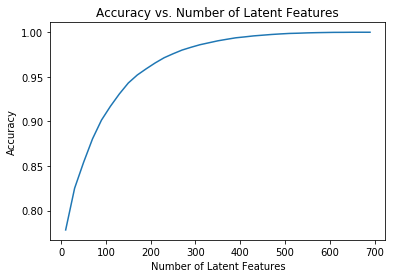

In [40]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    

# Note: fixed bug in calculate here (used entire number of cells instead length of index)
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(df.shape[0] * df.shape[1]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [41]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    tf = ask.transformer.UserItemTransformer(user_col='user_id', item_col='article_id', value_col='title', binarize=True)
    user_item_train = tf.transform(df_train)
    user_item_test = tf.transform(df_test)
    test_idx = np.array(user_item_test.index)
    test_arts = np.array(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [42]:
irel_test_user = np.setdiff1d(test_idx, np.array(user_item_train.index))
rel_test_user = np.setdiff1d(test_idx, irel_test_user)
print("Relevant Test User: {} / Irrelevant Test User: {}".format(len(rel_test_user), len(irel_test_user)))
irel_test_arts = np.setdiff1d(test_arts, np.array(user_item_train.columns))
rel_test_arts = np.setdiff1d(test_arts, irel_test_arts)
print("Relevant Test Articles: {} / Irrelevant Test Articles: {}".format(len(rel_test_arts), len(irel_test_arts)))

Relevant Test User: 20 / Irrelevant Test User: 662
Relevant Test Articles: 574 / Irrelevant Test Articles: 0


In [43]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

# NOTE: there was an error in the project_test (last two questions referencing movies instead of articles)

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [44]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)

In [45]:
def test_latent(latent, rel_user_item_test, user_item_train, s_train, u_train, vt_train):
    '''Functions to test the SVD based on the given number of latent features against a test set.
    
    Returns:
        train_err (float): Number of total misses in the train set
        test_err (float): Number of total misses in the test set (based on train SVD)
    '''
    # restructure with latent features
    s_new, u_new, vt_new = np.diag(s_train[:latent]), u_train[:, :latent], vt_train[:latent, :]
    
    # take dot product (reconstruct user-item)
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # select the relevant items
    user_item_est = pd.DataFrame(user_item_est)
    user_item_est.columns = user_item_train.columns
    user_item_est.index = user_item_train.index
    # select only the test relevant portion
    rel_user_item_est = user_item_est.loc[np.array(rel_user_item_test.index), np.array(rel_user_item_test.columns)]

    
    # total errors and keep track of them
    test_err = np.sum(np.sum(np.abs( np.subtract(rel_user_item_test, rel_user_item_est) )))
    train_err  = np.sum(np.sum(np.abs( np.subtract(user_item_train, user_item_est) )))
    
    return train_err, test_err

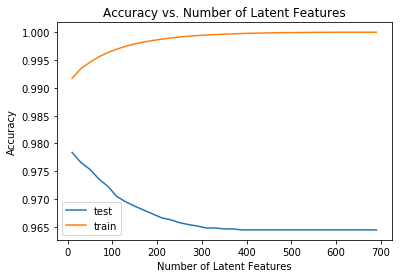

In [46]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# setup vars
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []
sum_errs_train = []
# retrieve the relevant test portion
rel_user_item_test = user_item_test.loc[rel_test_user, rel_test_arts]

# iterate over the number of latent features
for k in num_latent_feats:
    # calculate the errors
    train_err, test_err = test_latent(k, rel_user_item_test, user_item_train, s_train, u_train, vt_train)

    # append to lists
    sum_errs.append(test_err)
    sum_errs_train.append(train_err)
    
# plot resulting graphs
fig, ax = plt.subplots()
ax.plot(num_latent_feats, 1 - np.array(sum_errs)/(rel_user_item_test.shape[0] * rel_user_item_test.shape[1]), label='test');
ax.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0] * user_item_train.shape[1]), label='train');

# format plot
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

Mean interactions per User in train set: 8.914642
Mean interactions per User in relevant train set: 1.052632


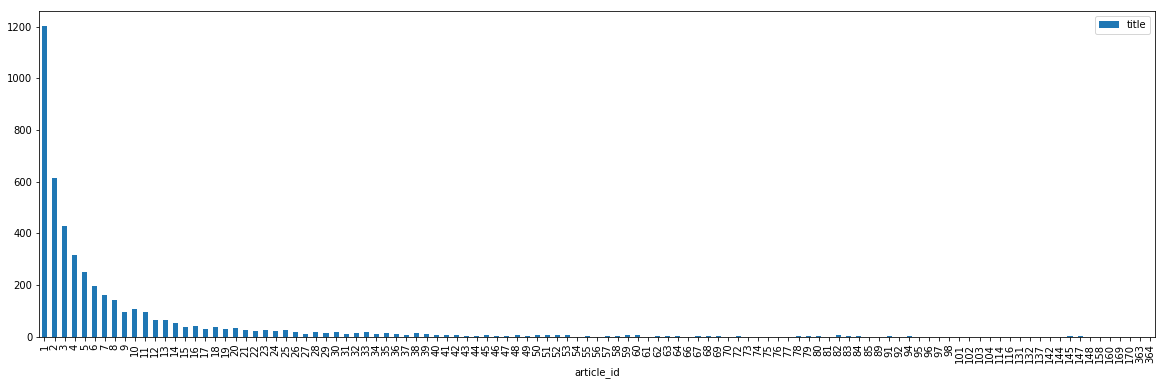

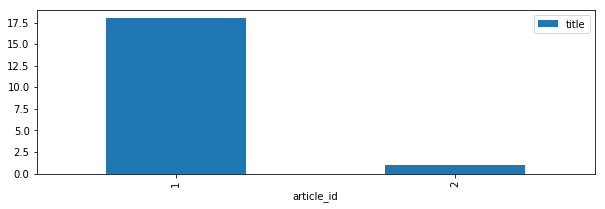

In [47]:
its1 = df_train.groupby('user_id').count()
print("Mean interactions per User in train set: {:.6f}".format(its1['article_id'].mean()))

its2 = df_train.loc[rel_test_user].groupby('user_id').count()
print("Mean interactions per User in relevant train set: {:.6f}".format(its2['article_id'].mean()))
its1.groupby('article_id').count().plot.bar(figsize=(20, 6));
its2.groupby('article_id').count().plot.bar(figsize=(10, 3));

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

***Answer:*** 

**Current Test:**

Based on the split of the data, we can only make predictions for 20 users in the test set (albeit for 574 articles). When we look at the data distribution, we notice two things: The distribution of the train set appears to match the distribution of the entire dataset (with a mean of 8.9 interactions with different articles per user). However, the data in the test we are making predictions on, has a different distribution (only 1.05 interactions per user). This indicates that the conclusions we make from this test set might not generalize well.

Regarding the test scores, we can see, that while the accuracy on the train set raises continuously with the number of features, the test score declines. One possible explanation for this behaviour is overfitting. It is likely that the train data contains some kind of noise that is captured by a higher number of latent features, while this noise is not present (or perturbed) in the test data, leading to a decline in results. That being said, I don't recommend drawing conclusions about the number of features from the given experiment, as the number of users in the relevant test set is low and out of sample. It can well be that higher latent features (e.g. 200 or 300) still capture meaningful information, which is just not present in the given test data.

**Recommendation Strength:**

The easiest way to identify the strength of recommendations would be to capture relevance feedback from the users (either through direct questionairs (e.g. was this item relevant to you) or through indirect measures (e.g. number of interactions in recommended articles)). To compare different recommenders against each other, one might resort to A/B Testing (splitting the users and using different recommender systems for each, again using a measure how well the articles statisfy the information need of the user as a goal).

The recommender systems seen here are mostly focused on relevance to the user. Given additional metadata (e.g. data of posting of articles), system might also be able to introduce novelty (which might be important for the use-case of data-science knowledge). Another possible improvement would be to leverage domain specific knowledge (e.g. relation between fields in the area of Deep Learning) and classification of articles thereby to introduce serendipty into the recommenders.

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1